Machine Learning Model for predicting Conversion and Snygas Ratio for Nickel-catalysed DRM
<br> Using Random Forest (RF), Gradient Boosted Tree (GBR), Extreme Gradient Boosting (XGB) and CAT to predict syngas production gas
<br> Requires the required .csv file in the same folder location
<br>
<br> If some package is missing, use the command: "import sys !{sys.executable} -m pip install package"
<br> 
<br> First, Import Relevant Libraries

In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,  KFold, ShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import time
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

Define helper functions for filtering

In [33]:
def filtery(df):
    thres = 0.5 # filter top 99 and bottom 1 percentile
    df3 = df
    upper_thres = np.percentile(df3.Syngas_Ratio,thres)
    lower_thres = np.percentile(df3.Syngas_Ratio,100-thres)
    df3 = df3[upper_thres < df3.Syngas_Ratio]
    df3 = df3[df3.Syngas_Ratio < lower_thres]
    df3 = df3.reset_index()
    print("Before, there are {} data points in y".format(len(df.index)))
    print("After filtering, there are {} data points in filtered y".format(len(df3.index)))
    return df3

Converts .csv file to pandas Dataframe and plot the distribution of the dataset

In [34]:
def plttarget(targets, titles: str) -> None:
    ticksize = 15
    fsize = 16
    ''' To plot distributions of the target features'''
    '''To plot subplots for Syngas ratio, CH4 conversion and CO2 conversion'''
    plt.figure(figsize=(5,14/3))
    plt.hist(targets[0], bins=50)
    plt.xticks(fontsize= ticksize)
    plt.yticks(fontsize= ticksize)
    plt.ylabel("N",fontsize=fsize)
    #plt.xlabel("Syngas Ratio",fontsize=18)
    plt.xlabel("Syngas Ratio",fontsize=fsize)
    plt.show()

    plt.figure(figsize=(5,14/3))
    plt.hist(targets[1], bins=50)
    plt.xticks(fontsize= ticksize)
    plt.yticks(fontsize= ticksize)
    plt.ylabel("N",fontsize=fsize)
    #plt.xlabel("$CH_{4}$ Conversion",fontsize=18)
    plt.xlabel("$CH_{4}$ Conversion (%)",fontsize=fsize)
    plt.show()

    plt.figure(figsize=(5,14/3))
    plt.hist(targets[2], bins=50)
    plt.xticks(fontsize= ticksize)
    plt.yticks(fontsize= ticksize)
    plt.ylabel("N",fontsize=fsize)
    #plt.xlabel("$CO_{2}$ Conversion",fontsize=18)
    plt.xlabel("$CO_{2}$ Conversion (%)",fontsize=fsize)
    #plt.tight_layout
    plt.show()


def csv2df(location: str, obj="syngas", nodispersion=True):
    '''Converts .csv file in location to Pandas DataFrame
    returns df, unnormalized features X, and targets y'''
    try: # Reading csv files
        df = pd.read_csv(location, header = 0, index_col = False, encoding = 'utf-8')
        print(df)
    except:
        print(".csv file not found in folder, put file in same folder as this .ipynb notebook")
    
    try: # Reading data to see if they are formatted correctly
        if nodispersion:
            try:
                df = df.drop(columns=["Ni Dispersion"])
            except:
                print("Error occured during filtering")
        else:
            df = df.dropna(subset=["Syngas_Ratio", "Ni Particle Size", "Ni Dispersion"])
        try:
            features = df.loc[:,"Ratio of CH4 in Feed":"GHSV"] 
            features = features.dropna(axis=0)
        except:
            print("Error occurred when extracting features")
        if obj == "conv":
            target0 = df.loc[:,"Syngas_Ratio"]
            df = df.dropna(subset=["CH4 Conversion", "CO2 Conversion"])
            target1 = df.loc[:, "CH4 Conversion"]
            target2 = df.loc[:, "CO2 Conversion"]
            features = df.loc[:,"Ratio of CH4 in Feed":"GHSV"]

        #plttarget([target0, target1, target2], ["Syngas Ratio","CH4 Conversion", "CO2 Conversion"])

    except: 
        print("csv file is read, but there is a formatting error")
    return df, features, target1, target2

# NOTE: the csv_file have to be in the same folder as this .ipynb file 
df, X, y1, y2 = csv2df("Final Complied.csv",obj = 'conv',nodispersion=True)

                Catalyst  Ratio of CH4 in Feed  Reaction Temperature  \
0            Ni−SiO2‑550                  0.15                 650.0   
1            Ni−SiO2‑750                  0.15                 650.0   
2      Ni/Sn0.2−SiO2‑550                  0.15                 650.0   
3      Ni/Sn0.2−SiO2‑750                  0.15                 650.0   
4     Ni/Sn0.05−SiO2‑550                  0.15                 650.0   
...                  ...                   ...                   ...   
1709              Ni-IMP                  0.50                 750.0   
1710            Ni/CZ100                  0.50                 700.0   
1711             Ni/CZ75                  0.50                 700.0   
1712             Ni/CZ44                  0.50                 700.0   
1713             Ni/CZ28                  0.50                 700.0   

      Ni Loading  Reaction Time  Pore Size  Pore Volume  Surface Area  \
0          10.00            0.5        4.7         0.58       

Generate the median and skew of the dataset

In [35]:
def median_skew(df):
    print(f"The median is: {df.median()}")
    print(f"The skew is: {df.skew()}")

# For CH4 Conversion
median_skew(y1)
# For CO2 Conversion
median_skew(y2)

The median is: 64.615
The skew is: -0.48682169662243835
The median is: 72.4
The skew is: -0.8123741511713454


Define helper functions for successive function calls

In [36]:
def pltshap(model, features, cat=False):
    '''To plot shap figures'''
    if cat:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(features,check_additivity=False)
    else:
        explainer = shap.Explainer(model, features)
        shap_values = explainer(features,check_additivity=False)
    
    '''plt.figure(), shap.plots.waterfall(shap_values[0]), plt.show()'''
    plt.figure()
    shap.plots.beeswarm(shap_values)
    plt.show()
    
def evalscore(model, Xtrain, Xtest, ytrain, ytest):
    '''returns model score, trainMSE, testMSE, trainR2, testR2'''
    score = model.score(Xtest, ytest)
    model_train_pred = model.predict(Xtrain)
    model_test_pred = model.predict(Xtest)
        
    r2train = r2_score(ytrain, model_train_pred)#, multioutput='raw_values')
    r2test = r2_score(ytest, model_test_pred)#, multioutput='raw_values')
        
    trainMSE = mean_squared_error(ytrain, model_train_pred)#, multioutput='raw_values')
    trainMSE = trainMSE **0.5
        
    testMSE = mean_squared_error(ytest, model_test_pred)#, multioutput='raw_values')
    testMSE = testMSE**0.5
        
    return score, trainMSE, testMSE, r2train, r2test, model_train_pred, model_test_pred

def plotfeatureimportance(importances, perimportance, printf=False):
    '''To plot feature importance sorted in terms of priority'''
    indices = np.argsort(importances)[::-1] 
    # Print the feature ranking
    if printf:
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    # Plot the feature importances
    fig = plt.figure(figsize=(14, 6))
    ax = plt.subplot(1, 2, 1)
    y_ticks = np.arange(len(X.columns.values))
    ax.barh(y_ticks,importances[indices],height=0.6)
    ax.set_yticklabels(X.columns[indices])
    ax.set_yticks(y_ticks)
    ax.invert_yaxis()
    label_x = ax.get_xticklabels()
    plt.tick_params(axis='x',labelsize=14) 
    plt.tick_params(axis='y',labelsize=14)
    plt.xlabel('Value of Importance', fontsize=16)        
    plt.title("Feature Importance Plot", fontsize=17)

    # Plot the permutation importance
    plt.subplot(1, 2, 2)
    sorted_idx = perimportance.importances_mean.argsort()
    plt.boxplot(perimportance.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx])
    plt.title("Permutation Importance (test set)", fontsize=17)
    plt.xlabel("Permutation Importance of Feature", fontsize=16)
    plt.tick_params(axis='x',labelsize=14) 
    plt.tick_params(axis='y',labelsize=14)
    fig.tight_layout()
    plt.show()

def plotscatter(ytrain, ytest, ytrainpred, ytestpred):    
    plt.figure(figsize=(7,7)) # create basic scatterplot     
    plt.plot(ytrain, ytrainpred, "^", color='violet', markersize=10, markeredgecolor='white',markeredgewidth=1)

    m, b = np.polyfit(ytest, ytestpred, 1) # obtain m (slope) and b(intercept) of linear regression line
    plt.plot(ytest, ytestpred, '^', color='green',markersize=10, markeredgecolor='white',markeredgewidth=0.5) # Scatter plot
    plt.plot(ytest, m*ytest+b, color='green', linewidth=2)  # add linear regression line to scatterplot
    plt.legend(["Train Set Prediction", "Test Set Prediction"], fontsize=12, loc = 'lower right')
    plt.xlabel("Actual Targets", fontsize = 15)
    plt.ylabel("Predicted Targets", fontsize = 15)
    plt.title("Model Prediction", fontsize = 16, weight="bold")
    plt.show()

def threedpdp(model, target, Xtrain, feature_tuple, grid=40, inv_y=False, inv_x=False):
    titlesize = 20
    ticksize = 15
    labelsize = 18
    plt.rc('font', size=14)
    plt.rcParams['axes.labelpad'] = 20
    xname, yname = X.columns[feature_tuple[0]], X.columns[feature_tuple[1]]
    fig = plt.figure(figsize=(9,9))
    pdp = partial_dependence(model, Xtrain, features=feature_tuple, kind="average", grid_resolution=grid)
    xval, yval = pdp["values"][0], pdp["values"][1]
    XX, YY = np.meshgrid(xval, yval)
    Z = pdp.average[0].T      
    ax = fig.add_subplot(projection="3d")

    fig.add_axes(ax)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap="viridis", edgecolor="k")
    ax.set_xlabel(xname, fontsize=labelsize)
    if yname == "GHSV":
        ax.set_ylabel("     GHSV     ", fontsize = labelsize)
        ax.ticklabel_format( axis="y",style="sci", scilimits=(3,3))
    else:
        ax.set_ylabel(yname, fontsize=labelsize)
    
    if inv_y:
        buffer = (max(yval)-min(yval))*0.03
        ax.set_ylim(max(yval)+buffer, min(yval)-buffer)

    if inv_x:
        buffer = (max(xval)-min(xval))*0.03
        ax.set_xlim(max(xval)+buffer, min(xval)-buffer)
    
    # pretty init view
    ax.view_init(elev=30, azim=135)
    plt.colorbar(surf, ax=ax,shrink=0.5, pad=0.1)
    plt.xticks(size = ticksize)
    plt.yticks(size = ticksize)
    ax.zaxis.set_tick_params(labelsize=ticksize)
    if target == "CH4":
        plt.title("Partial dependence of ${CH_4}$ Conversion" + " on \n {} and {}".format(xname, yname), fontsize = titlesize)
    else:
        plt.title("Partial dependence of ${CO_2}$ Conversion" + " on \n {} and {}".format(xname, yname), fontsize = titlesize)
    plt.tight_layout()
    plt.show()

def onepdp(model,Xtrain, low=0,up=0.95, **kwargs):
    plt.rcParams['axes.labelpad'] = 6
    options = {'gbr':False, "cat":True}
    options.update(**kwargs)
    fig, axes = plt.subplots(figsize=(13, 13))
    #axes.set_title("Partial Dependence Plots of Features on Syngas Ratio", fontsize = 16)
    featureNames = ["Ratio of ${CH_4}$ in Feed", "Reaction Temperature (˚C)", "Ni Loading (%)","Reaction Time (h)","Pore Size (nm)","Pore Volume (cm³/g)","Surface Area (m²/g)","H2-TPR Peak Temperature (˚C)", "Ni Particle Size (nm)", "Modifier Electronegativity","GHSV (ml/gcat/h)"]
    fig = PartialDependenceDisplay.from_estimator(model,Xtrain, features = list(i for i in range(0,Xtrain.shape[1])), feature_names=featureNames,
    n_jobs=3, grid_resolution = 25, ax=axes, percentiles = (0,1), line_kw = {"linestyle":"--","linewidth":2, "marker":"o", "markersize":3.2})

    for i in fig.axes_:
        for j in i:
            if (j!=None):
                j.xaxis.label.set_size(16)
                j.yaxis.label.set_size(16)
                j.tick_params(axis='both', which='major', labelsize=14)
                j.set_yticks((20,40,60,80))
                j.set_yticklabels((20,40,60,80))
                j.set_ylabel("Conversion (%)", fontsize = 16)
                j.set_ylim(15,95)

    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
    plt.show()


def plotpartial(model,target, Xtrain, oneway=True,twoway=False, catalyst=True, process = True):
    '''To plot partial dependence plots'''    
    t1 = time.time()
    if oneway:
        onepdp(model, Xtrain, cat=True)
    t2 = time.time()

    print("Time taken for one way pdp is {:.2f} seconds".format(t2-t1))
    if twoway: 
        # Catalyst properties: [(2,8),(5,8),(5,7),(7,8)]
        # Process Parameters; [(0,1),(1,10),(0,10)]
        if catalyst:
            catalst = [(2,8),(5,8),(5,7),(7,8)]
            for i in catalst:
                t3 = time.time()
                if (i==(2,8)):
                    threedpdp(model, target, Xtrain, i, grid=40)
                elif (i == (5,7)):
                    threedpdp(model, target,Xtrain, i, inv_y=True,grid=40)
                else:
                    threedpdp(model, target,Xtrain, i, grid=40)
                t4 = time.time()
                print("Time taken for 1st two way pdp is {:.2f} seconds".format(t4-t3))

        if process: 
            process = [(0,1),(1,10),(0,10)]
            for j in process:
                t4 = time.time()
                if (j==(0,10)):
                    threedpdp(model, target,Xtrain, j, grid=40, inv_x=True)
                elif (j==(0,1)):
                    threedpdp(model,target, Xtrain, j, grid=40, inv_x=True, inv_y=True)
                else:
                    threedpdp(model,target, Xtrain, j,  grid=40)
                t5 = time.time()
                print("Time taken for 1st two way pdp is {:.2f} seconds".format(t5-t4))


Splitting Training Dataset (90%) and Testing Data (10%) <br>

In [37]:
def splitdata(X,y,r,scale=False):
    '''Takes in features (X) and target/s (y) and split data sets
    Outputs the Normalized features (X) and targets (y)'''
    test_percent = 0.10 # Part of data used for testing
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_percent, random_state = r) #random_state = 42
    
    # Normalize input features (x) into normlized features (X) using MinMaxScaler
    # Not actually used
    if scale:
        norm_x = StandardScaler().fit(X_train) # transform training data
        X_train = norm_x.transform(X_train) # transform testing dataabs
        X_test = norm_x.transform(X_test)
    return X_train, X_test, y_train, y_test


X_train1, X_test1, y_train1, y_test1 = splitdata(X, y1, 0) # CH4 Conversion
X_train2, X_test2, y_train2, y_test2 = splitdata(X, y2, 0) # CO2 Conversion


Train the RF model and test its performance

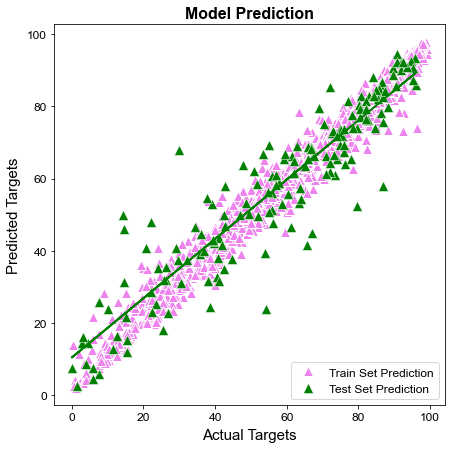

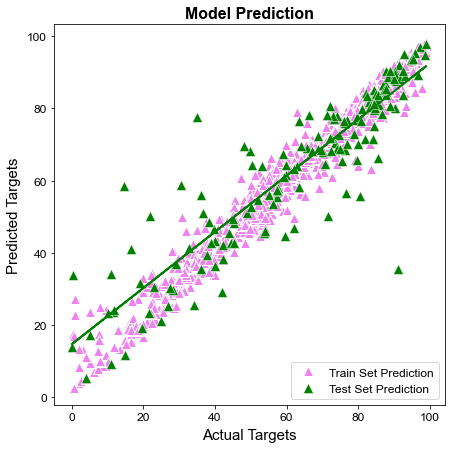

In [38]:
def rf(Xtrain, Xtest, ytrain, ytest, **kwargs):
    '''Random Forest Regressor, returns mean test score and plot relevant plots
    By default we dont plot and print anything'''
    options = {"model_num":1, "scatterplot":False, "featureplot":False, "partialdep":False, "shap":False, "doprint":False, "target":"CH4"}
    options.update(kwargs)
    model_num = options["model_num"]
    target = options["target"]
    FtrainR2, FtestR2 = 0, 0 # Training and Testing R square
    FtrainRMSE, FtestRMSE  = 0, 0 # Training and Testing residual MSE
    FScore = 0 # Cumulative Score
    
    for j in range(0,model_num):
        RF = RandomForestRegressor(n_estimators=2000, max_depth=100,random_state=0).fit(Xtrain, ytrain)
        fscore, trainMSE, testMSE, rtrain, rtest, RF_train_pred, RF_test_pred = evalscore(RF, Xtrain, Xtest, ytrain, ytest)
        FScore += fscore
        FtrainR2 += rtrain
        FtestR2 += rtest
        FtrainRMSE += trainMSE
        FtestRMSE += testMSE

    if options["scatterplot"]:
        plotscatter(ytrain, ytest, RF_train_pred, RF_test_pred)

    if options["partialdep"]:
        plotpartial(RF,target,Xtrain)
        
    if options["featureplot"]:
        '''To plot partial dependence plot for RF'''
        importances = RF.feature_importances_
        perimportance = permutation_importance(RF, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2)
        plotfeatureimportance(importances, perimportance)
    
    if options["shap"]:
        pltshap(RF, Xtrain)

    if options["doprint"]:
        print("The RF average training score is "), print(FtrainR2/model_num) 
        print("The RF average training Root-mean-square deviation is "), print(FtrainRMSE/model_num)
        print("The RF average testing Root-mean-square deviation is "), print(FtestRMSE/model_num)
    
    return [FtestRMSE/model_num,FScore/model_num], [ytrain, ytest, RF_train_pred, RF_test_pred]

rfscore1, rf_lst1 = rf(X_train1, X_test1, y_train1, y_test1, scatterplot=True, shap=False) # CH4
rfscore2, rf_lst2 = rf(X_train2, X_test2, y_train2, y_test2, scatterplot=True, shap=False) # CO2

Train the GBR models and test its performance

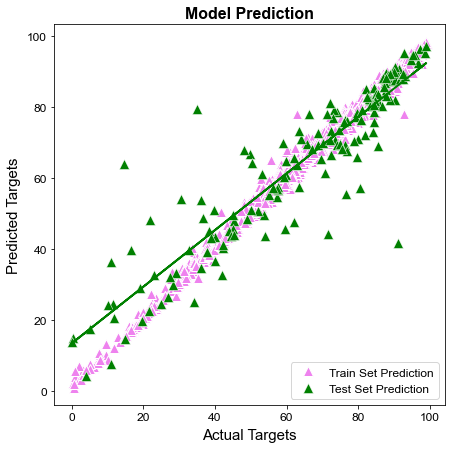

In [39]:
def gbr(Xtrain, Xtest, ytrain, ytest, **kwargs):
    '''Gradient Boosting Tree Training, returns Score
    By default we dont print anything'''
    options = {"model_num":1, "scatterplot":False, "featureplot":False, "partialdep":False,"doprint":False, "shap": False, "target":"CH4"}
    options.update(kwargs)
    model_num = options["model_num"]
    target = options["target"]
    GtrainR2, GtestR2 = 0, 0 # Training and Testing R square
    GtrainRMSE, GtestRMSE  = 0, 0 # Training and Testing residual MSE
    GScore = 0 # Cumulative Score
    
    for j in range(0,model_num):
        lr = 50/10000
        GBR = GradientBoostingRegressor(n_estimators=1000, learning_rate=lr, subsample=0.7, max_depth = 10, random_state = 1).fit(Xtrain, ytrain)
        
        gscore, trainMSE, testMSE, rtrain, rtest, GBR_train_pred, GBR_test_pred = evalscore(GBR, Xtrain, Xtest, ytrain, ytest)
        GScore += gscore
        GtrainR2 += rtrain
        GtestR2 += rtest
        GtrainRMSE += trainMSE
        GtestRMSE += testMSE
    
    if options["scatterplot"]:
        plotscatter(ytrain, ytest, GBR_train_pred, GBR_test_pred)

    if options["partialdep"]:
        plotpartial(GBR, target, Xtrain, gbr=True)
        
    if options["featureplot"]:
        '''To plot partial dependence plot for GBR'''
        importances = GBR.feature_importances_
        perimportance = permutation_importance(GBR, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2)
        plotfeatureimportance(importances, perimportance)
    
    if options["shap"]:
        pltshap(GBR, Xtrain)
        
    if options["doprint"]:
        print("The GBR average training score is "), print(GtrainR2/model_num) 
        print("The GBR average training Root-mean-square deviation is "), print(GtrainRMSE/model_num)
        print("The GBR average testing Root-mean-square deviation is "), print(GtestRMSE/model_num)

    return [GtestRMSE/model_num, GScore/model_num], [ytrain, ytest, GBR_train_pred, GBR_test_pred]

gbrscore1, gbr_lst1 = gbr(X_train1, X_test1, y_train1, y_test1, scatterplot=True, shap=False) # CH4
gbrscore2, gbr_lst2 = gbr(X_train2, X_test2, y_train2, y_test2, scatterplot=True, shap=False) # CO2

Train the CAT model and plot the PDP plots for the features

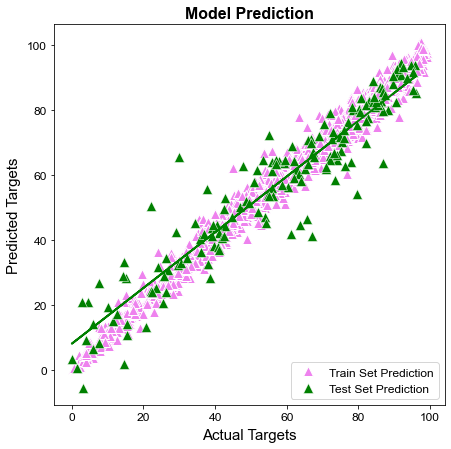

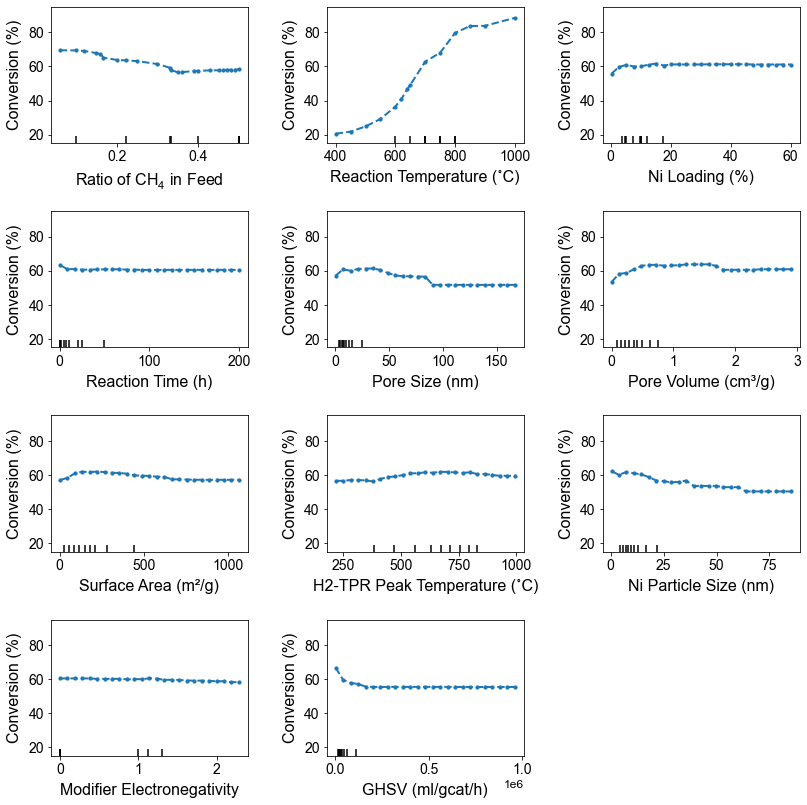

Time taken for one way pdp is 4.00 seconds


Time taken for 1st two way pdp is 6.86 seconds


Time taken for 1st two way pdp is 6.81 seconds


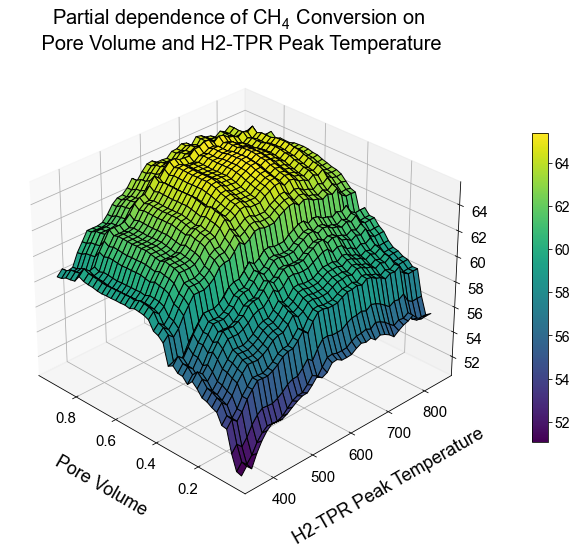

Time taken for 1st two way pdp is 6.76 seconds


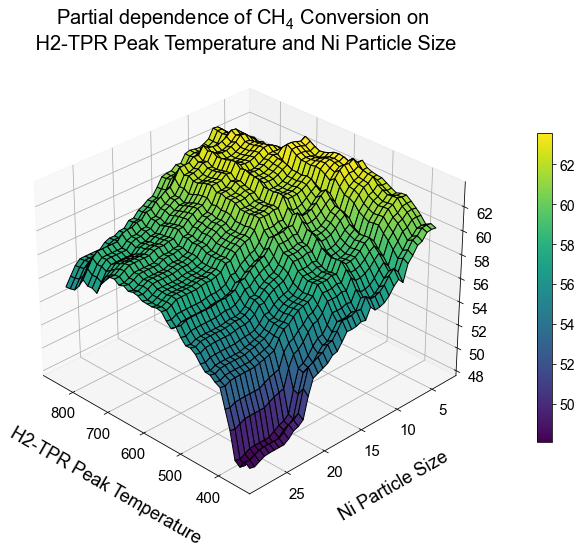

Time taken for 1st two way pdp is 6.63 seconds


Time taken for 1st two way pdp is 1.58 seconds


Time taken for 1st two way pdp is 2.61 seconds


Time taken for 1st two way pdp is 4.04 seconds


0.8945318410128082


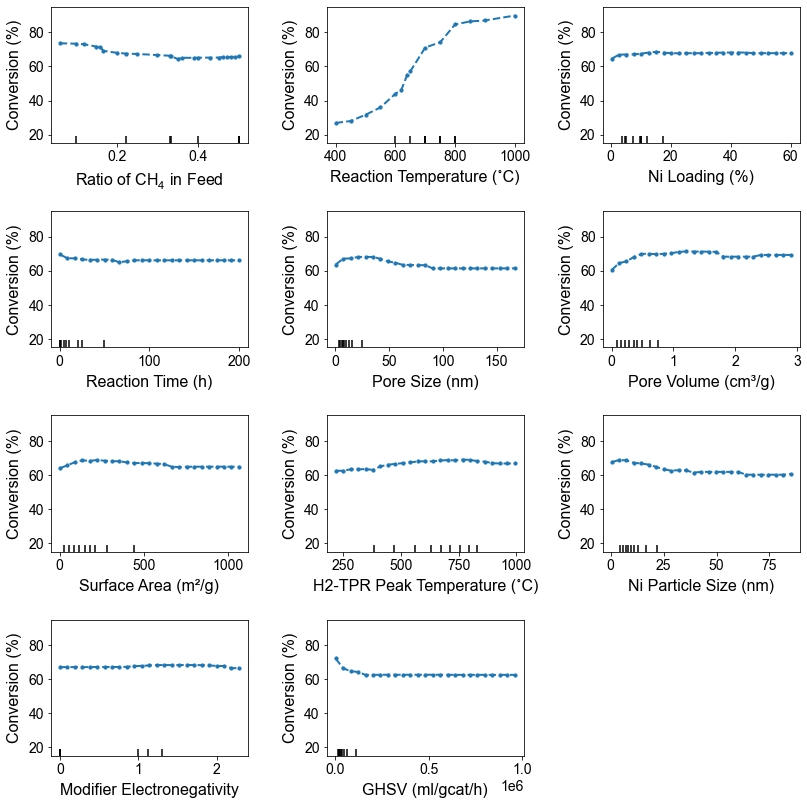

Time taken for one way pdp is 1.58 seconds


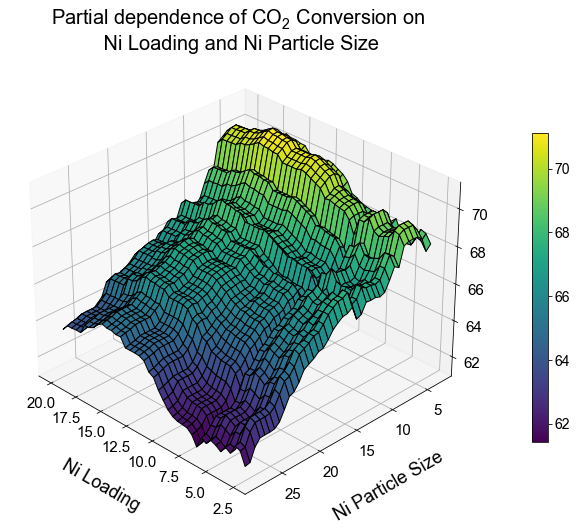

Time taken for 1st two way pdp is 6.75 seconds


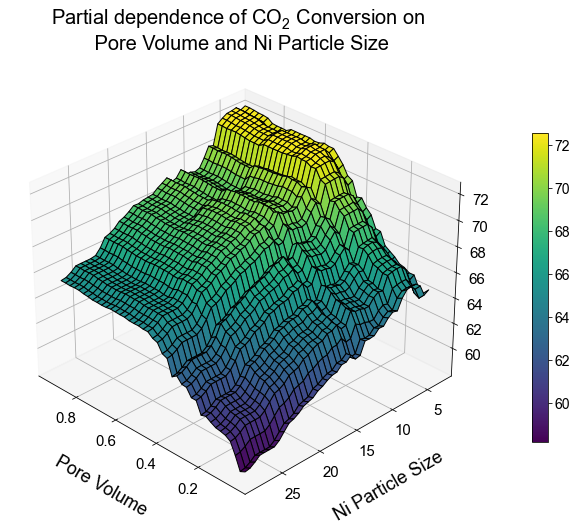

Time taken for 1st two way pdp is 6.72 seconds


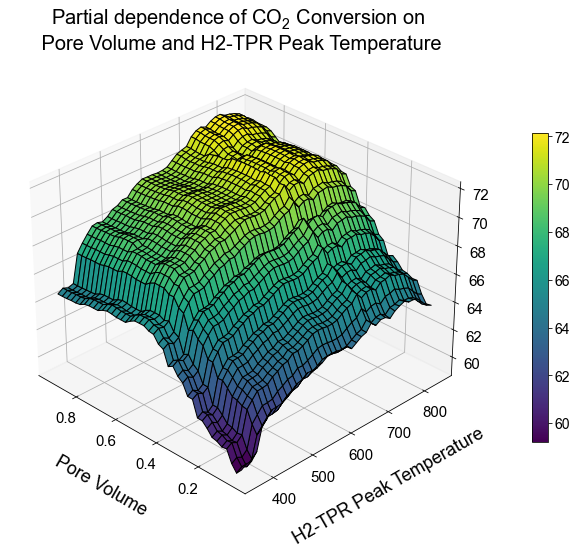

Time taken for 1st two way pdp is 7.24 seconds


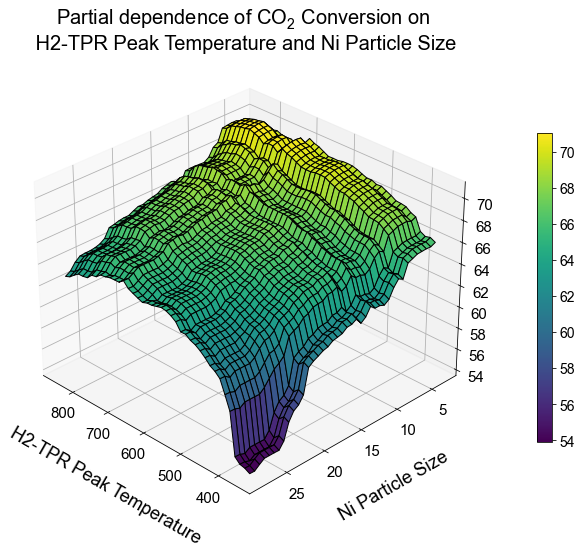

Time taken for 1st two way pdp is 7.35 seconds


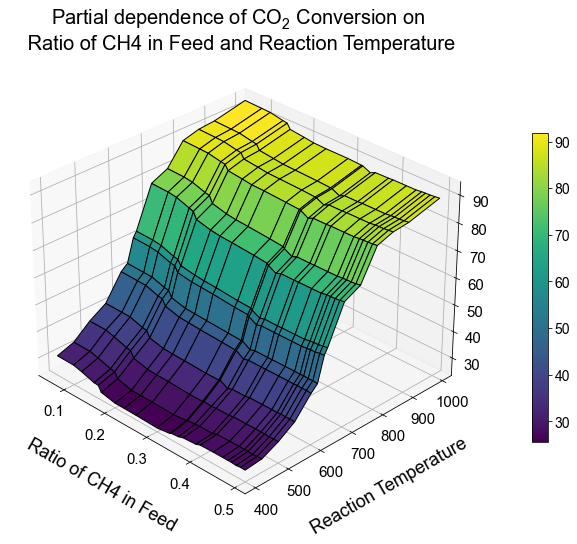

Time taken for 1st two way pdp is 1.85 seconds


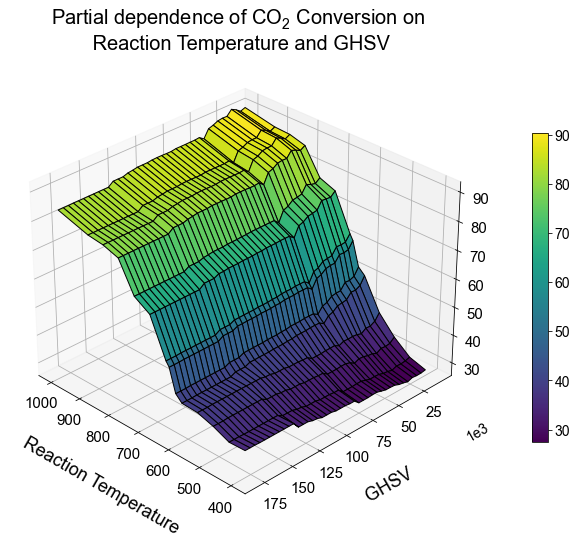

Time taken for 1st two way pdp is 2.90 seconds


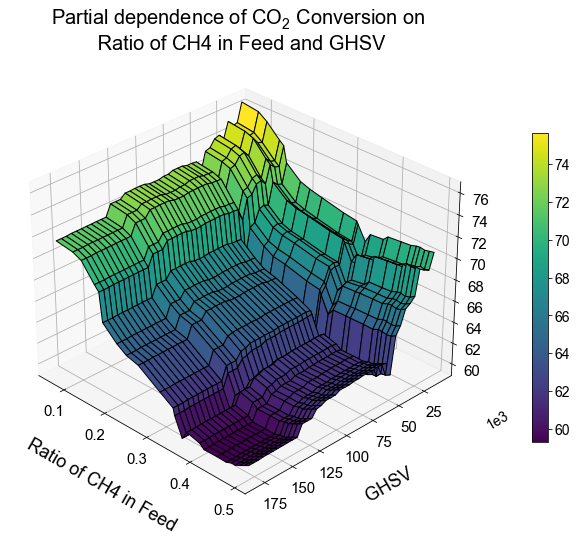

Time taken for 1st two way pdp is 4.74 seconds


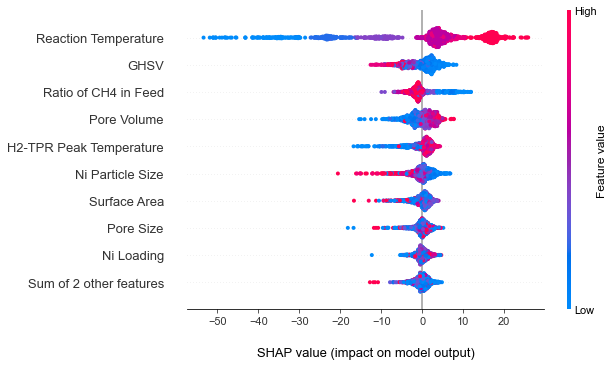

0.8753789424092022


In [40]:
def cat(Xtrain, Xtest, ytrain, ytest, **kwargs):
    '''CAT Gradient Boosting Tree Training and Performance testing
    Takes the normalized features and labels to return a training score'''
    options = {"model_num":1, "scatterplot":False, "featureplot":False, "partialdep":False,"doprint":False, "savemodel":False, "shap":False,"target":"CH4"}
    options.update(kwargs)
    model_num = options["model_num"]
    target = options["target"]
    CtrainR2, CtestR2 = 0, 0 # Training and Testing R square
    CtrainRMSE, CtestRMSE = 0, 0 # Training and Testing residual MSE
    CScore = 0 # Cumulative Score
    
    pool = Pool(Xtrain, ytrain, feature_names=list(X.head(0)))
    for j in range(0,model_num):
        '''CAT Regressor, tune the n_estimators and learning_rate'''
        CAT = CatBoostRegressor(n_estimators= 1000, depth = 8, verbose=0).fit(pool)

        cscore, trainMSE, testMSE, rtrain, rtest, CAT_train_pred, CAT_test_pred = evalscore(CAT, Xtrain, Xtest, ytrain, ytest)
        CScore += cscore
        CtrainR2 += rtrain
        CtestR2 += rtest
        CtrainRMSE += trainMSE
        CtestRMSE += testMSE
       
    if options["scatterplot"]:
        plotscatter(ytrain, ytest, CAT_train_pred, CAT_test_pred)
        
    if options["partialdep"]:
        plotpartial(CAT, target,Xtrain, oneway=True, twoway=True)
        
    if options["featureplot"]:
        '''To plot partial dependence plot for CAT'''
        importances = (CAT.feature_importances_/100)
        perimportance = permutation_importance(CAT, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2)
        plotfeatureimportance(importances, perimportance)

    if options["shap"]:
        pltshap(CAT, Xtrain, cat=True)    
        
    if options["doprint"]:
        print("The CAT average training score is "), print(CtrainR2/model_num) 
        print("The CAT average training Root-mean-square deviation is "), print(CtrainRMSE/model_num)
        print("The CAT average testing Root-mean-square deviation is "), print(CtestRMSE/model_num)

    print(CScore)
    return CAT, [CtestRMSE/model_num,CScore/model_num], [ytrain, ytest, CAT_train_pred, CAT_test_pred]
    
ch4mdl, score, cat_lst = cat(X_train1, X_test1, y_train1, y_test1, scatterplot=True, shap=True, partialdep=True) # CH4
co2mdl, score, cat_lst = cat(X_train2, X_test2, y_train2, y_test2, scatterplot=True, shap=True, partialdep=True, target="CO2") # CO2

To plot regression plot for RF, GBR, CAT for conversions

0.8945318410128082
0.8753789424092022


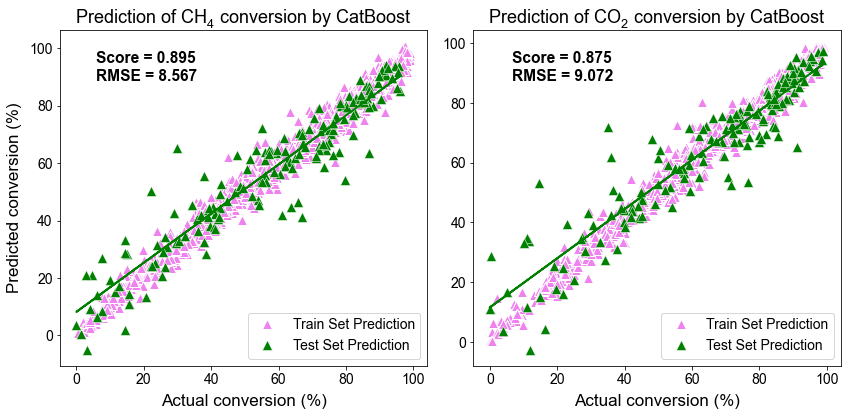

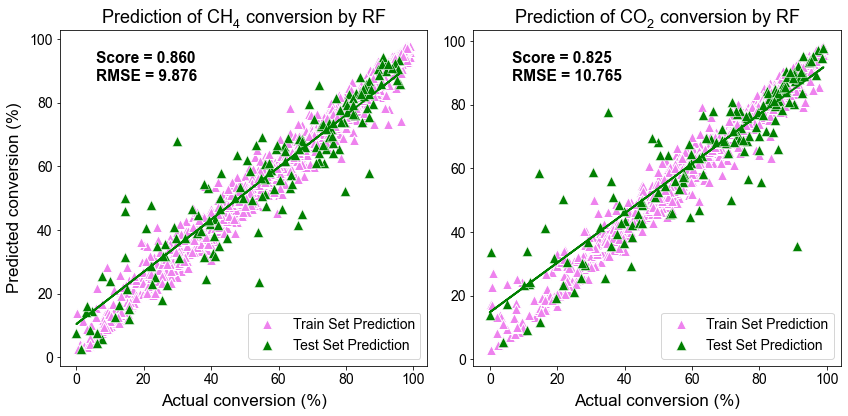

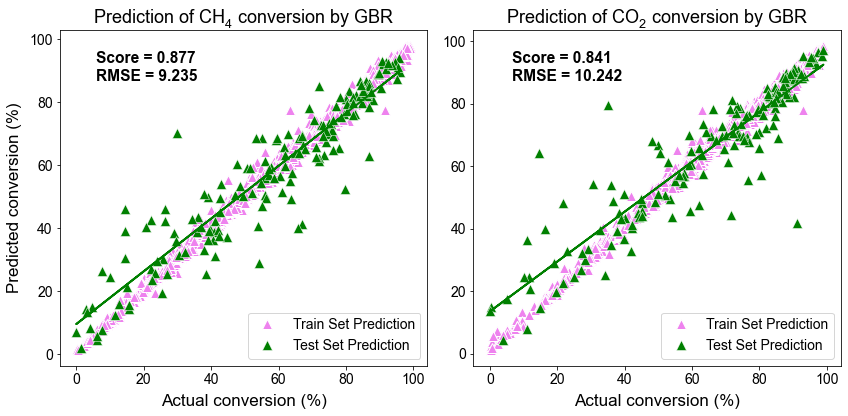

In [41]:
def pltreg(model, lst1, st1, lst2, st2):
    plt.rcParams['axes.labelpad'] = 7
    ticksize = 14
    textsize = 17
    legendsize = 14
    titlesize = 18
    
    plt.figure(figsize=(12,6))
    ctrain1, ctest1, ctrainpred1, ctestpred1 = tuple(lst1)
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(ctrain1, ctrainpred1, "^", color='violet', markersize=10, markeredgecolor='white',markeredgewidth=1)
    m, b = np.polyfit(ctest1, ctestpred1, 1)
    ax1.plot(ctest1, ctestpred1, '^', color='green',markersize=10, markeredgecolor='white',markeredgewidth=0.5)
    ax1.plot(ctest1, m*ctest1+b, color='green', linewidth=2)
    ax1.legend(["Train Set Prediction", "Test Set Prediction"], fontsize=legendsize, loc = 'lower right')
    ax1.text(0.1, 0.85,'Score = {:.3f} \nRMSE = {:.3f}'.format(st1[1], st1[0]),
     transform = ax1.transAxes, fontsize = 15.5 , fontweight = 'semibold')
    plt.xlabel("Actual conversion (%)", fontsize = textsize)
    plt.ylabel("Predicted conversion (%)", fontsize = textsize)
    plt.xticks(size = ticksize)
    plt.yticks(size = ticksize)
    plt.title("Prediction of ${CH_4}$ conversion by " + model, fontsize=titlesize)

    ctrain2, ctest2, ctrainpred2, ctestpred2 = tuple(lst2)
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    ax2.plot(ctrain2, ctrainpred2, "^", color='violet', markersize=10, markeredgecolor='white',markeredgewidth=1)
    m, b = np.polyfit(ctest2, ctestpred2, 1)
    ax2.plot(ctest2, ctestpred2, '^', color='green',markersize=10, markeredgecolor='white',markeredgewidth=0.5)
    ax2.plot(ctest2, m*ctest2+b, color='green', linewidth=2)
    ax2.legend(["Train Set Prediction", "Test Set Prediction"], fontsize=legendsize, loc = 'lower right')
    ax2.text(1.23, 0.85,'Score = {:.3f} \nRMSE = {:.3f}'.format(st2[1], st2[0]),
     transform = ax1.transAxes, fontsize = 15.5 , fontweight = 'semibold')
    plt.xlabel("Actual conversion (%)", fontsize = textsize)
    #plt.ylabel("Predicted conversion (%)", fontsize = textsize)
    plt.title("Prediction of ${CO_2}$ conversion by " + model, fontsize=titlesize)
    plt.xticks(size = ticksize)
    plt.yticks(size = ticksize)
    plt.tight_layout()
    plt.show()

def pltall():
    '''To combine regression plots for all models
    [ytrain, ytest, CAT_train_pred, CAT_test_pred]'''
    mdl1,cats1, catl1 = cat(X_train1, X_test1, y_train1, y_test1)
    mdl2,cats2, catl2 = cat(X_train2, X_test2, y_train2, y_test2)
    pltreg("CatBoost", catl1, cats1, catl2, cats2)

    rfs1, rfl1 = rf(X_train1, X_test1, y_train1, y_test1)
    rfs2, rfl2 = rf(X_train2, X_test2, y_train2, y_test2)
    pltreg("RF", rfl1, rfs1, rfl2, rfs2)
    
    gbs1, gbl1 = gbr(X_train1, X_test1, y_train1, y_test1)
    gbs2, gbl2 = gbr(X_train2, X_test2, y_train2, y_test2)
    pltreg("GBR", gbl1, gbs1, gbl2, gbs2)
    
pltall()